# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Imbalance-Learning" data-toc-modified-id="Imbalance-Learning-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imbalance Learning</a></div><div class="lev1 toc-item"><a href="#Reference" data-toc-modified-id="Reference-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Reference</a></div>

In [1]:
# 1. magic for inline plot
# 2. magic to print version
# 3. magic so that the notebook will reload external python modules
# 4. magic to enable retina (high resolution) plots
# https://gist.github.com/minrk/3301035
%matplotlib inline
%load_ext watermark
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt

%watermark -a 'Ethen' -d -t -v -p numpy,sklearn,matplotlib

Ethen 2017-11-19 20:18:13 

CPython 3.5.2
IPython 6.2.1

numpy 1.13.3
sklearn 0.19.1
matplotlib 2.1.0


# Imbalance Learning

Some classification problems requires dealing with data imbalance amonst classes. i.e. One class may have significantly higher/lower repesentation in the training dataset. In these scenarios, performance on the minority class is often of higher interest, and simply plugging in our favorite classification techniques may not give us the model performance that we were aiming for. Some quintessential problems that comes into mind is fraud detection (most of the payments are genuine, while only a few are fraudulent), disease diagnosis (a large proportion of the people are healthy).

The main techniques for dealing with these type of problems are:

1. Modify the loss function.
2. Modify the dataset (oversampling/undersampling).
3. Ensemble of the two.

Normally we would wish to have a high recall for the minority class (observations that belongs in the minority class actually gets flagged as the minority class), e.g. say we're detecting fraud, then we would like to catch all the fraudulent transactions at the risk of potentially flagging some genuine transactions. 

In [2]:
# generate some toy dataset, fit a logisitic regression
# and plot the decision boundary

from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

X, y = make_classification(
    class_sep = 1.2, weights = [0.1, 0.9],
    n_features = 5, n_informative = 3, n_redundant = 1,
    n_clusters_per_class = 1, n_samples = 10000,
    flip_y = 0, random_state = 10)

pca = PCA(n_components = 2)
X_pca = pca.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size = 0.3, random_state = 0, stratify = y)

X1, X2 = X_train[y_train == 1], X_train[y_train == 0]
np.bincount(y_train)

array([ 700, 6300])

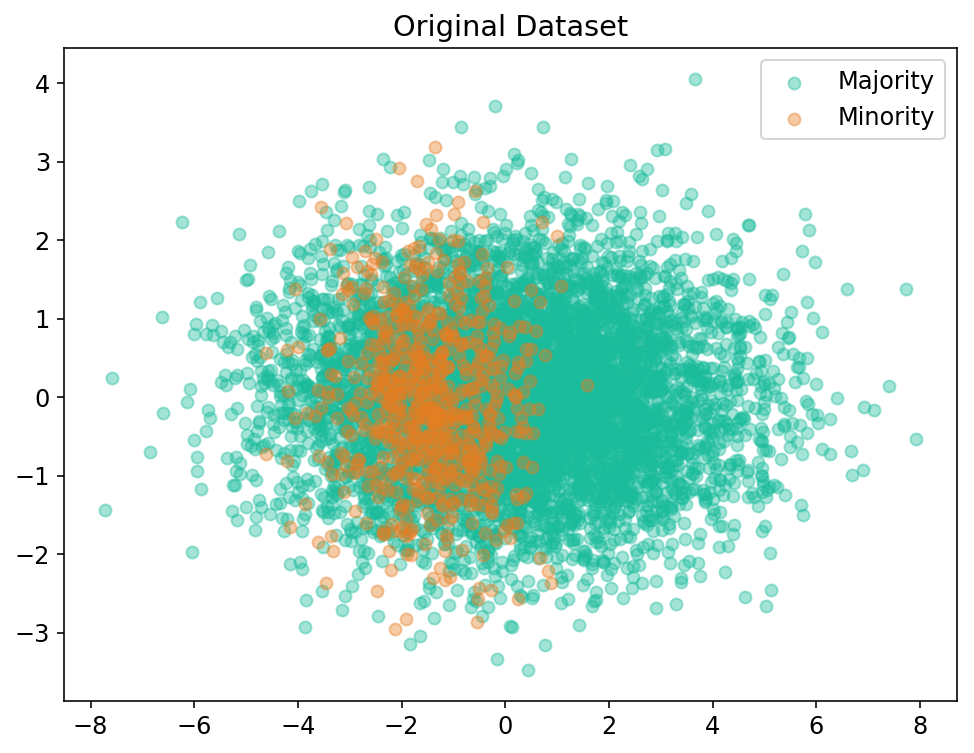

In [3]:
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12

plt.scatter(X1[:, 0], X1[:, 1], alpha = 0.4, c = '#1abc9c', label = 'Majority')
plt.scatter(X2[:, 0], X2[:, 1], alpha = 0.4, c = '#e67e22', label = 'Minority')
plt.legend()
plt.title('Original Dataset')
plt.show()

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

logistic = LogisticRegression()
tuned_params = {
    'C': [0.1, 0.5, 1],
    'penalty': ['l1', 'l2']}

grid_search = GridSearchCV(
    estimator = logistic,
    param_grid = tuned_params,
    cv = 5,
    n_jobs = 1,
    scoring = 'f1')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.1, 0.5, 1], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

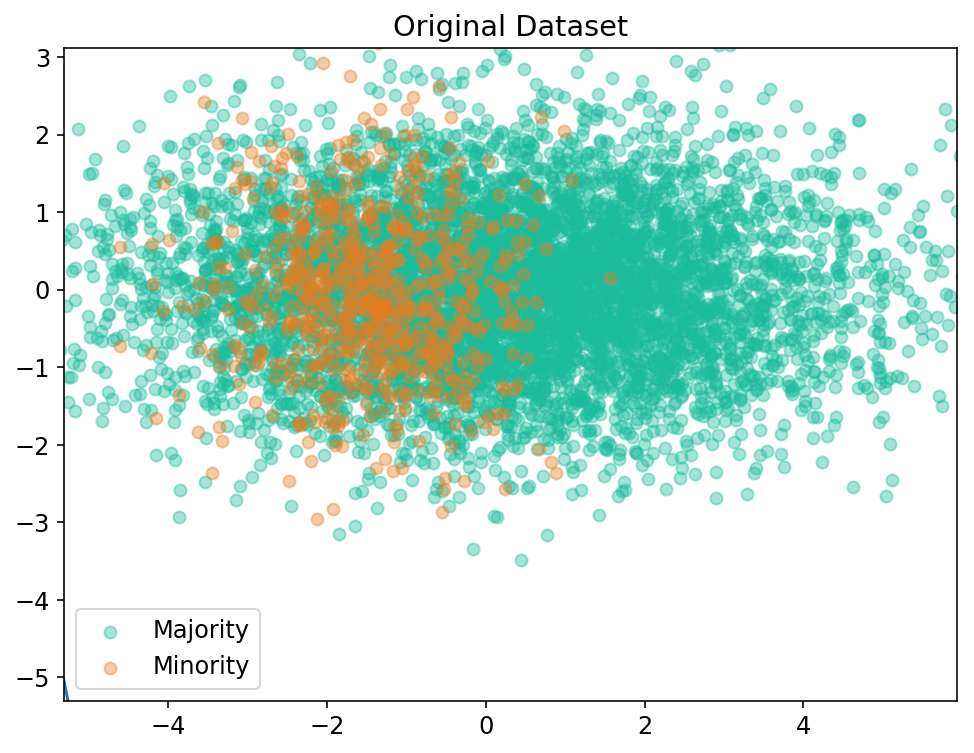

In [15]:
best = grid_search.best_estimator_
coef = best.coef_
intercept = best.intercept_

x1 = np.linspace(-8, 4, 100)
# http://www.okaythenwhat.com/0011
x2 = -(coef[0][0] * x1 + intercept[0]) / coef[0][1]

plt.scatter(X1[:, 0], X1[:, 1], alpha = 0.4, c = '#1abc9c', label = 'Majority')
plt.scatter(X2[:, 0], X2[:, 1], alpha = 0.4, c = '#e67e22', label = 'Minority')
plt.axis([
    np.min(X[:, 0]) - 0.5, np.max(X[:, 0]) + 0.5,
    np.min(X[:, 1]) - 0.5, np.max(X[:, 1]) + 0.5])
plt.plot(x1, x2)
plt.legend()
plt.title('Original Dataset')
plt.show()

In [6]:
from sklearn.metrics import classification_report

print(classification_report(y_test, best.predict(X_test)))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00       300
          1       0.90      1.00      0.95      2700

avg / total       0.81      0.90      0.85      3000



Assymetric objective/loss function. Unless specified otherwise, most classification algorithm assumes the cost of making a mistake is a same across all classes, but we can modify that by attaching a weight to each class. By doing so, we are essentially encoding the information that we care more about the performance on the minority class.

In [7]:
# specify balanced class weight, which attaches
# weights that are inversely proportional to the size of each class
logistic = LogisticRegression(class_weight = 'balanced')
tuned_params = {
    'C': [0.1, 0.5, 1],
    'penalty': ['l1', 'l2']}

grid_search = GridSearchCV(
    estimator = logistic,
    param_grid = tuned_params,
    cv = 5,
    n_jobs = 1,
    scoring = 'f1')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.1, 0.5, 1], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

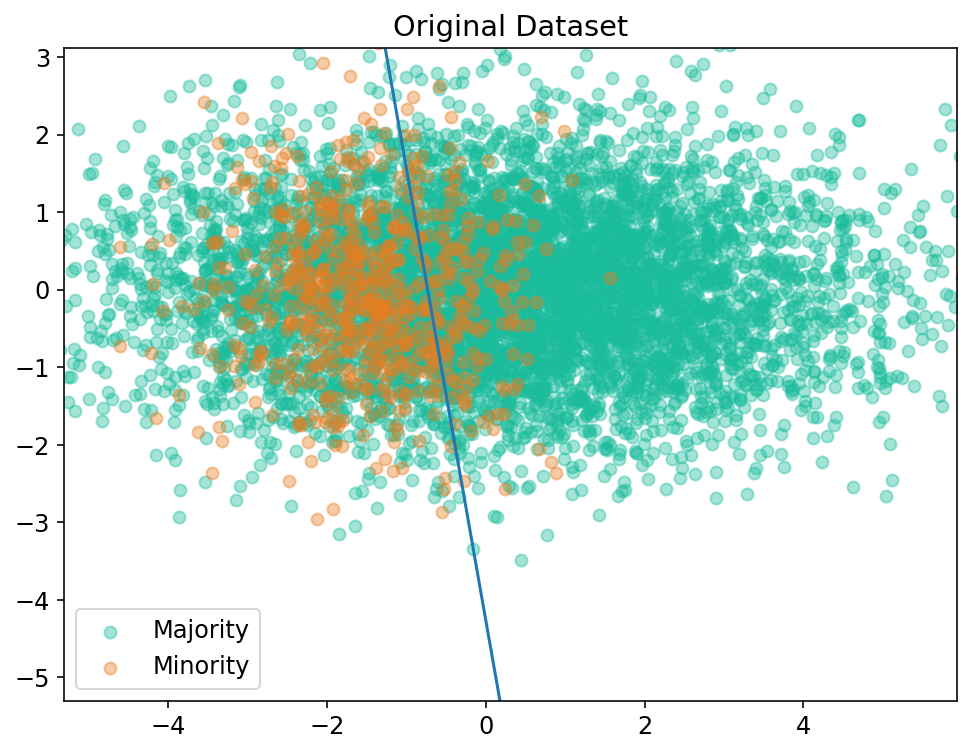

In [8]:
best = grid_search.best_estimator_
coef = best.coef_
intercept = best.intercept_

x1 = np.linspace(-4, 4, 100)
x2 = -(coef[0][0] * x1 + intercept[0]) / coef[0][1]

plt.scatter(X1[:, 0], X1[:, 1], alpha = 0.4, c = '#1abc9c', label = 'Majority')
plt.scatter(X2[:, 0], X2[:, 1], alpha = 0.4, c = '#e67e22', label = 'Minority')
plt.axis([
    np.min(X[:, 0]) - 0.5, np.max(X[:, 0]) + 0.5,
    np.min(X[:, 1]) - 0.5, np.max(X[:, 1]) + 0.5])
plt.plot(x1, x2)
plt.legend()
plt.title('Original Dataset')
plt.show()

In [9]:
print(classification_report(y_test, best.predict(X_test)))

             precision    recall  f1-score   support

          0       0.19      0.75      0.30       300
          1       0.96      0.65      0.77      2700

avg / total       0.88      0.66      0.73      3000



The first idea is to randomly undersample the majority class, where we treat each observation equally and randomly drop a certain number of them. The drawback of this approach is that we can lose informative examples.

In [10]:
from imblearn.under_sampling import RandomUnderSampler

under_sampler = RandomUnderSampler(ratio = 'majority', random_state = 1)
X_train_sampled, y_train_sampled = under_sampler.fit_sample(X_train, y_train)
np.bincount(y_train_sampled)

array([700, 700])

In [11]:
logistic = LogisticRegression()
tuned_params = {
    'C': [0.1, 0.5, 1],
    'penalty': ['l1', 'l2']}

grid_search = GridSearchCV(
    estimator = logistic,
    param_grid = tuned_params,
    cv = 5,
    n_jobs = 1,
    scoring = 'f1')
grid_search.fit(X_train_sampled, y_train_sampled)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.1, 0.5, 1], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

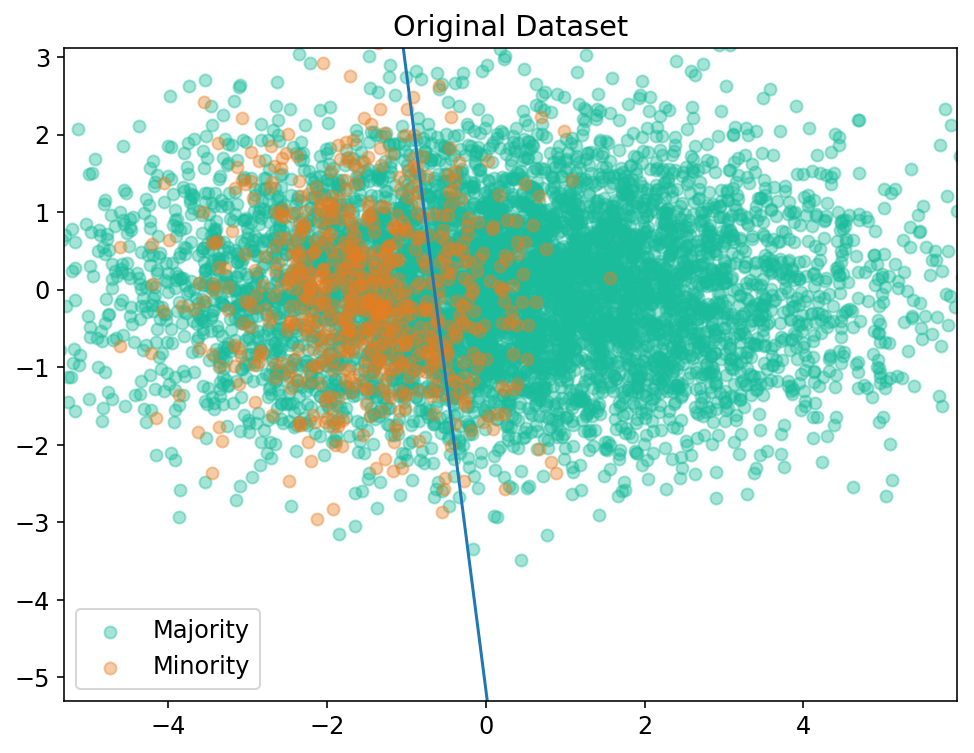

In [12]:
best = grid_search.best_estimator_
coef = best.coef_
intercept = best.intercept_

x1 = np.linspace(-4, 4, 100)
x2 = -(coef[0][0] * x1 + intercept[0]) / coef[0][1]



plt.scatter(X1[:, 0], X1[:, 1], alpha = 0.4, c = '#1abc9c', label = 'Majority')
plt.scatter(X2[:, 0], X2[:, 1], alpha = 0.4, c = '#e67e22', label = 'Minority')
plt.axis([
    np.min(X[:, 0]) - 0.5, np.max(X[:, 0]) + 0.5,
    np.min(X[:, 1]) - 0.5, np.max(X[:, 1]) + 0.5])
plt.plot(x1, x2)
plt.legend()
plt.title('Original Dataset')
plt.show()

In [13]:
print(classification_report(y_test, best.predict(X_test)))

             precision    recall  f1-score   support

          0       0.19      0.76      0.30       300
          1       0.96      0.63      0.76      2700

avg / total       0.88      0.65      0.72      3000



In [30]:
y_count = np.bincount(y_train)
y_count

array([ 700, 6300])

In [42]:
def ratio_multiplier(y, multiplier):
    """callable needs to return a dict-like object"""
    target_stats = np.bincount(y)
    target_stats = {idx: int(value * multiplier[idx])
                    for idx, value in enumerate(target_stats)}
    return target_stats

multiplier = {0: 1.0, 1: 0.4}
ratio = lambda y, multiplier = multiplier: ratio_multiplier(y, multiplier)
ratio

<function __main__.<lambda>>

In [47]:
under_sampler = RandomUnderSampler(ratio = ratio, random_state = 1)
X_train_sampled, y_train_sampled = under_sampler.fit_sample(X_train, y_train)
np.bincount(y_train_sampled)

array([ 700, 2520])

In [92]:
multiplers = [0.75, 0.8, 0.85, 0.9]
ratio_range = [{0: multiplier} for multiplier in multiplers]
ratio

[{0: 0.75}, {0: 0.8}, {0: 0.85}, {0: 0.9}]

In [93]:
joblib.hash(y_train)

'da73b5db2d9faaf4fa19d7a7b177d342'

In [75]:
ratio = {0: 1.0, 1: 0.5}
ratio_ = check_ratio(ratio, y_train)
ratio_

{0: 700, 1: 3150}

In [ ]:
from sklearn.datasets import load_iris

iris = load_iris()

print('Information of the original iris data set: \n {}'.format(
    np.bincount(iris.target)))

ratio = {0: 10, 1: 20, 2: 30}
X, y = make_imbalance(iris.data, iris.target, ratio=ratio)

# Reference

- https://www.youtube.com/watch?v=-Z1PaqYKC1w
- https://www.slideshare.net/PyData/python-resampling-65637486
- https://github.com/mldataanalysis/Dealing-With-Imbalanced-Data/blob/master/1%20-%20Results.ipynb
- https://cs.nju.edu.cn/zhouzh/zhouzh.files/publication/tsmcb09.pdf
- http://www.okaythenwhat.com/0011